In [165]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [166]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [167]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 4 classes.


In [168]:
class_names = dataset.class_names
class_names

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [169]:
class_names

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [170]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 1 1 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 1 2 1 1 2 2 3 1 1]


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


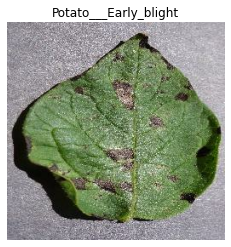

In [171]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        print(image_batch[i].shape)

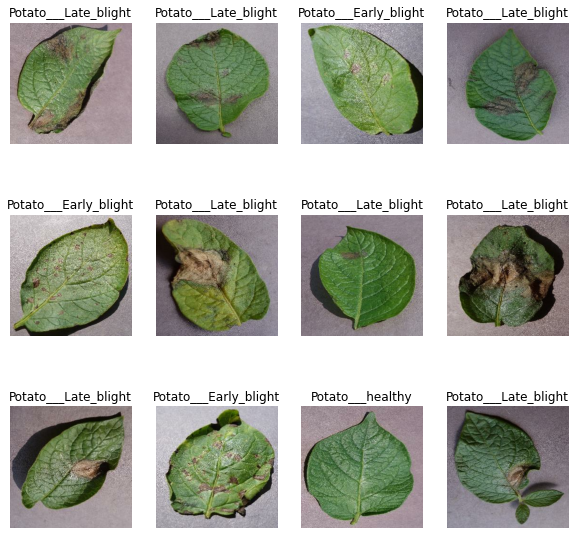

In [172]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> validation, 10% test

In [173]:
len(dataset)


68

In [174]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [175]:
train_ds = dataset.take(54)
len(train_ds)

54

In [176]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [177]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [178]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [179]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [180]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [181]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [182]:
len(train_ds)

54

In [183]:
len(val_ds)


6

In [184]:
len(test_ds)


8

In [185]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [186]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [187]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [188]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [189]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [190]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_67 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (32, 60, 60, 64)        

In [191]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [192]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


InvalidArgumentError:  Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 2 3 1 2 1 3 1 1 1 1 3 1 3 1 1 2 1 1 2 1 2 1 1 1 1 3 1 2 1 1 1 1
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at C:\Users\dhira\anaconda3\lib\site-packages\keras\backend.py:5113)
]] [Op:__inference_train_function_18449]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at C:\Users\dhira\anaconda3\lib\site-packages\keras\backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at C:\Users\dhira\anaconda3\lib\site-packages\keras\backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "C:\Users\dhira\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
>>>     yield self.process_one()
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 250, in wrapper
>>>     runner = Runner(ctx_run, result, future, yielded)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 741, in __init__
>>>     self.ctx_run(self.run)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-192-2ed193659f6e>", line 1, in <module>
>>>     history = model.fit(
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "C:\Users\dhira\anaconda3\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 